In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
import pandas as pd 
import pandas.io.data as web
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [122]:
class FDAmPrice:
    # initialize the class
    def __init__(self, Smax, ds, T, dt, X, fRate, sd):
        self.Smax = Smax
        self.pRange = int(np.ceil(Smax / ds))
        self.ds = Smax / self.pRange
        self.tRange = int(np.ceil(T / dt))
        self.T = T
        self.dt = T / self.tRange
        self.X = X
        self.R = fRate
        self.sd = sd
        
        
    # FE method for put pricing
    def FEput(self,np):
        J = np.array(range(self.pRange-1))
        a = 0.5 * self.R * self.dt * J - 0.5 * self.sd ** 2 * self.dt * J ** 2
        b = 1 + self.sd ** 2 * self.dt * J **2 + self.R * self.dt
        c = -0.5 * self.R * self.dt * J - 0.5 * self.sd ** 2 * self.dt * J ** 2
        A = np.diag(b) + np.diag(a[1 : self.pRange - 1], -1) + np.diag(c[0 : self.pRange-2], 1)
        A = np.matrix(A)
        put = np.zeros([self.tRange + 1, self.pRange + 1])
        put[self.tRange,:] = [np.max([self.X - p, 0]) for p in np.arange(0,self.Smax + self.ds, self.ds)]
        
        for i in range(self.tRange + 1): 
            put[i,0] = self.X
            
        put[:, self.pRange] = 0

        for i in np.arange(self.tRange , -1 , -1 ):
            y = put[i,1 : self.pRange]
            y = y.T
            y = np.array(y)
            y[0] = y[0] - a[0] * self.X
            put[i - 1, 1 : self.pRange]= np.linalg.solve(A,y).T
            put[i - 1] = [np.max([self.X - p1, p2]) for p1, p2 in zip(np.arange(0 , self.Smax + self.ds , self.ds ),put[i-1])]
        self.FEput = put
        return put
    
    
    # Backward Euler 
    def BEput(self,np):
        J = np.array(range(self.pRange-1))
        a = (-0.5 * self.R * self.dt * J + 0.5 * self.sd ** 2* self.dt * J ** 2) / (1 + self.R * self.dt)
        b = (1 - self.sd ** 2 *self.dt * J ** 2) / (1 + self.R * self.dt)
        c = (0.5 * self.R * self.dt * J + 0.5 * self.sd ** 2 * self.dt * J ** 2 ) / (1 + self.R * self.dt)
        A = np.diag(b) + np.diag(a[1 : self.pRange - 1], -1) + np.diag(c[0: self.pRange - 2], 1)
        A = np.matrix(A)
        put = np.zeros([self.tRange + 1, self.pRange + 1])
        put[self.tRange,:] = [np.max([self.X - p, 0]) for p in np.arange(0,self.Smax + self.ds, self.ds)]
        
        for i in range(self.tRange + 1): 
            put[i,0] = self.X
            
        put[:, self.pRange] = 0

        for i in np.arange(self.tRange , -1 , -1 ):
            y = np.zeros([1,self.pRange - 1])
            y = np.array(y)
            y[0,0] = a[0] * put[i, 0]
            y[0,self.pRange - 2] = c[self.pRange - 2] * put[i, self.pRange] 
            put[i - 1, 1 : self.pRange]= put[i, 1 : self.pRange] * A.T + y
            put[i - 1] = [np.max([self.X - p1, p2]) for p1, p2 in zip(np.arange(0 , self.Smax + self.ds , self.ds )
                                                                      ,put[i-1])]
        self.BEput = put
        return put
        
        
        
        # Plot
    def plot3d(self, plt, cm, option = 'FE'):
        X = np.arange(0 , self.Smax + self.ds , self.ds)
        Y = np.arange(0 , self.T + self.dt, self.dt)
        X,Y = np.meshgrid(X , Y)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        res = []
        if option == 'BE':
            res = self.BEput
        elif option == 'FE':
            res = self.FEput
        surf = ax.plot_surface(X , Y , res , rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        fig.colorbar(surf, shrink=0.5, aspect=10)
        plt.gcf().set_size_inches(15,8)
            



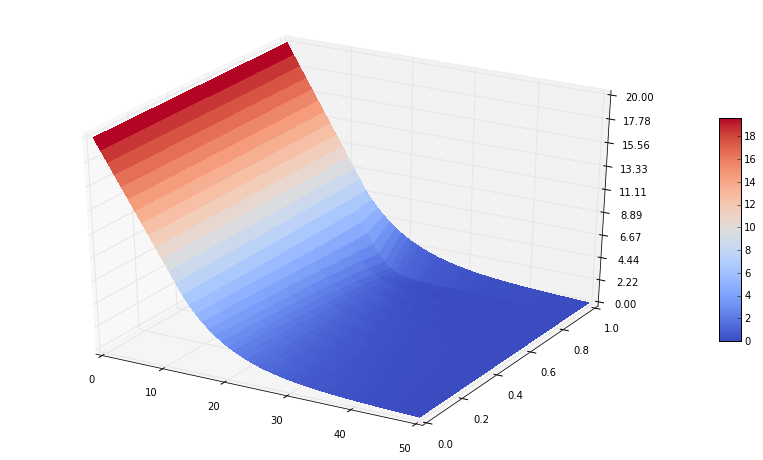

In [136]:
S1 = FDAmPrice(50,1,1,0.1,20,0.1,0.5)
res = []
res = S1.FEput(np)
S1.plot3d(plt,cm, 'FE')
